In [183]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# For this assignment, I decided to study the emotion of HAPPINESS

# Task 1:
# I generated a dataset of 200 samples from the given link and generated their corresponding csv files
# However, out of the 200 samples, I got csv files for 126 samples, because the other onedid not contain a face
# or simply could not be processed by OpenFace

# You can find the csv and gif files in my submission

In [ ]:
# Task 2:
# The approach that I followed was to generate a K-Means model
# For that I decided to use Silhouette values as well as manual visualisation to determine the
# optimal number of clusters for the K-Means Model

In [184]:
# I started with importing the csv files and concatenating it into one large dataframe

import pandas as pd
import glob

# Set the path to the csv files
path = r'/content/drive/My Drive/happiness_csv'
all_files = glob.glob(path + "/*.csv")

li = []

# Read and append csv files to create a large dataframe
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    df["file_name"] = str(filename)[38:-4]
    li.append(df)

# Concatenate the dataframe together
frame = pd.concat(li, axis=0, ignore_index=True)

# Convert the dataframe into a csv file (if needed)
# frame.to_csv(r'/content/drive/My Drive/dframe.csv', index = False)

In [185]:
# Make a column list which considers the columns with AUs in csv files
colList = [' AU01_r',' AU02_r',' AU04_r',' AU05_r',' AU06_r',' AU07_r',' AU09_r',' AU10_r',' AU12_r',' AU14_r',' AU15_r',' AU17_r',' AU20_r',' AU23_r',' AU25_r',' AU26_r',' AU45_r',' AU01_c',' AU02_c',' AU04_c',' AU05_c',' AU06_c',' AU07_c',' AU09_c',' AU10_c',' AU12_c',' AU14_c',' AU15_c',' AU17_c',' AU20_c',' AU23_c',' AU25_c',' AU26_c',' AU28_c',' AU45_c',]
frame_au = frame[colList]

In [186]:
# Standard imports required
import os
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from sklearn import mixture

In [187]:
import umap

# Applying UMAP to do Dimensionality Reduction to 2 dimensions
# Using the default n_neighbors value of 15
frame_au_2d = umap.UMAP(n_neighbors=15).fit_transform(frame_au)   # frame_au_2d is the dataframe after being reduced to 2 dimensions

# I tried not using UMAP,since we are using K Means, but the multi-dimensional data was taking very long to run
# Also, I could not plot the graph with the clusters without using UMAP, so I decided to use UMAP

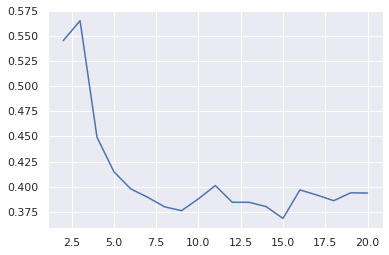

In [189]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Here, we use Silhouette scores to determine the optimal number of clusters for K Means clustering
# THIS IS WITHOUT USING DYNAMIC TIME WARPING

sil = []    # Array to store silhouette values
kmax = 20
k_range = range(2,kmax+1) # We set the minimum number of clusters to 2, because otherwise, we will not be able to find dissimilarities

for k in k_range:
  kmeans = KMeans(n_clusters = k).fit(frame_au_2d)
  labels = kmeans.labels_
  sil.append(silhouette_score(frame_au_2d, labels, metric = 'euclidean'))

# Plot the graph of k-values versus Silhouette scores
plt.plot(k_range,sil)

In [ ]:
# From the graph computed above, we find that the Silhouette scores are maximum for number of clusters = 2
# Now, we will find optimal number of cluster WITH Dynamic Time Warping

In [ ]:
# Install tslearn
! pip install tslearn

In [ ]:
from tslearn.clustering import TimeSeriesKMeans, silhouette_score

# Generate the K-Means model, using the distance metric Dynamic Time Warping
# Number of clusters = 2 (considering the value computed by the calculation given above)
km = TimeSeriesKMeans(n_clusters=2, metric="dtw")
labels = km.fit_predict(frame_au_2d)

# Compute Silhouette Score for the model
silhouette_score(frame_au_2d, labels, metric="dtw")

# NOTE: This cell usually takes over an hour to run, on my device

In [ ]:
# The Silhouette Score for number of clusters = 2 was 0.52419
# The Silhouette Score for number of clusters = 3 was 0.42193
# NOTE: The reason I was not able to compute Silhouette Values for larger number of clusters is that it took over 80 minutes
# to compute it for only one value of number of clusters 

# We can see these Sihouette scores following a similar trend as the computations done before
# So we will consider n_clusters = 2 as the optimal value

/usr/local/lib/python3.6/dist-packages/tslearn/utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 2890 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


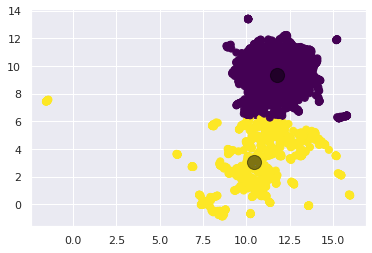

In [191]:
from tslearn.clustering import TimeSeriesKMeans

# Generate the K-Means model
# Using the distance metric Dynamic Time Warping
kmodel = TimeSeriesKMeans(n_clusters=2, metric="dtw").fit(frame_au_2d)   # Can change the n_clusters to visualize for different values
y_kmodel = kmodel.predict(frame_au_2d)

# I used .predict() by assigning to various row values of the csv to see which cluster a data belongs to, to find out which social signal it represents

plt.scatter(frame_au_2d[:, 0], frame_au_2d[:, 1], c=y_kmodel, s=50, cmap='viridis');
centers = kmodel.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In [ ]:
# I plotted and manually visualized the K-Means model for various values of n_clusters
# and still ended up with n_clusters = 2 as the best visible fit

In [ ]:
# I used .predict() by assigning to various row values of the csv to see which cluster a data belongs to and
# to find out which social signal it represents
print(y_kmodel[0])

# The index in the above line can be changed accordingly

In [ ]:
# I analyzed the gif files and the K-Means model manually and observed the presence of social signals
# I observed several social signals while observing the clips, while some of them seem to be present in almost all the clips
# For instance, Smiling with wide open mouth, Face movement while smiling seem to be present in majority of the clips, so
# these signals can't be used for differentiation

# However, I found some signals which were different
# The ones that I found are Body Movement and Hand Movement 

In [ ]:
# Task 3:
# I choose to analyze the social signal of BODY MOVEMENT

# I observed that clips in the cluster[0] involved Body Movement, while the clips in cluster[1] involved minimal to no Body Movement at all
# So I chose to examine this social signal further 

# I will first create the test and training datasets with a total of 30 examples
# They include the examples with and without my chosen social signal

In [192]:
# To create the Training data frame

# Set the path to the csv files
path = r'/content/drive/My Drive/training_dataset'
all_files_train = glob.glob(path + "/*.csv")

train_li = []

# Read and append csv files to create a large dataframe
for filename in all_files_train:
    df = pd.read_csv(filename, index_col=None, header=0)
    df["file_name"] = str(filename)[38:-4]
    train_li.append(df)

# Concatenate the dataframe together
frame_train = pd.concat(train_li, axis=0, ignore_index=True)

# Convert the dataframe into a csv file (if needed)
# frame_train.to_csv(r'/content/drive/My Drive/dframe_train.csv', index = False)

In [193]:
# To create the Test data frame

# Set the path to the csv files
path = r'/content/drive/My Drive/test_dataset'
all_files_test = glob.glob(path + "/*.csv")

test_li = []

# Read and append csv files to create a large dataframe
for filename in all_files_test:
    df = pd.read_csv(filename, index_col=None, header=0)
    df["file_name"] = str(filename)[38:-4]
    test_li.append(df)

# Concatenate the dataframe together
frame_test = pd.concat(test_li, axis=0, ignore_index=True)

# Convert the dataframe into a csv file (if needed)
#frame_test.to_csv(r'/content/drive/My Drive/dframe_test.csv', index = False)

In [194]:
# Make a column list which considers the columns with AUs in csv files
colList = [' AU01_r',' AU02_r',' AU04_r',' AU05_r',' AU06_r',' AU07_r',' AU09_r',' AU10_r',' AU12_r',' AU14_r',' AU15_r',' AU17_r',' AU20_r',' AU23_r',' AU25_r',' AU26_r',' AU45_r',' AU01_c',' AU02_c',' AU04_c',' AU05_c',' AU06_c',' AU07_c',' AU09_c',' AU10_c',' AU12_c',' AU14_c',' AU15_c',' AU17_c',' AU20_c',' AU23_c',' AU25_c',' AU26_c',' AU28_c',' AU45_c',]
f_au_train = frame_train[colList]
f_au_test = frame_test[colList]

In [195]:
# Apply UMAP to Train and Test Data
f_train_2d = umap.UMAP(n_neighbors=2).fit_transform(f_au_train)
f_test_2d = umap.UMAP(n_neighbors=2).fit_transform(f_au_test)

# I found out n_neighbors=2 as a decent value, since we have very less number of clusters
# Also, the model seems to perform better with this value

/usr/local/lib/python3.6/dist-packages/tslearn/utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 756 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


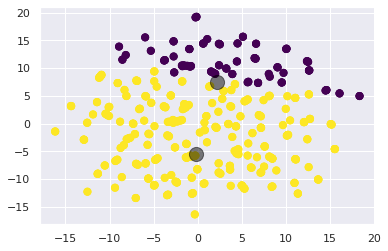

In [200]:
# Applying K-Means on Train Data
# K-Means using DTW and n_clusters=2

kmodel_train = TimeSeriesKMeans(n_clusters=2, metric="dtw").fit(f_train_2d)
y_kmodel_train = kmodel.predict(f_train_2d)

plt.scatter(f_train_2d[:, 0], f_train_2d[:, 1], c=y_kmodel_train, s=50, cmap='viridis');
centers_tr = kmodel_train.cluster_centers_
plt.scatter(centers_tr[:, 0], centers_tr[:, 1], c='black', s=200, alpha=0.5);

/usr/local/lib/python3.6/dist-packages/tslearn/utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 117 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


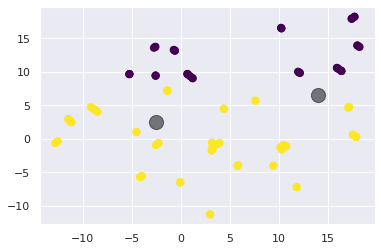

In [201]:
# Applying K-Means on Test Data
# K-Means using DTW and n_clusters=2
kmodel_test = TimeSeriesKMeans(n_clusters=2, metric="dtw").fit(f_test_2d)
y_kmodel_test = kmodel.predict(f_test_2d)

plt.scatter(f_test_2d[:, 0], f_test_2d[:, 1], c=y_kmodel_test, s=50, cmap='viridis');
centers_te = kmodel_test.cluster_centers_
plt.scatter(centers_te[:, 0], centers_te[:, 1], c='black', s=200, alpha=0.5);
 
# Error: This graph mostly shows two clusters
# However, it may sometimes show just one cluster, but I have not been able to figure out the reason for this
# Recreating the Test Dataframe usually helps to correct this error, but I'm not sure why this is the case
# Also, altering the n_neighbors value in UMAP helps to overcome this error
# which is the reason I chose n_neighbors = 2 as the optimal value for this

In [ ]:
# K-Nearest Neighbor for Train Data
# K=1
from tslearn.neighbors import KNeighborsTimeSeries
knn_tr = KNeighborsTimeSeries(n_neighbors=1)
knn_tr.fit(f_train_2d)

# Print K-Nearest Neighbors
print(knn_tr.kneighbors(f_train_2d))

# Print K-Nearest Neighbors Graph
print(knn_tr.kneighbors_graph(f_train_2d))

In [ ]:
# K-Nearest Neighbor for Test Data
# K=1
from tslearn.neighbors import KNeighborsTimeSeries
knn_te = KNeighborsTimeSeries(n_neighbors=1)
knn_te.fit(f_test_2d)
# Print K-Nearest Neighbors
print(knn_te.kneighbors(f_test_2d))

# Print K-Nearest Neighbors Graph
print(knn_te.kneighbors_graph(f_test_2d))

In [198]:
# Concatenate train and test data into one, for 5-fold Cross Validation

# NOTE: Making a new dataframe for k-fold might not be required, but could not find another way to figure this out.

# Set the path to the csv files
path = r'/content/drive/My Drive/fold_dataset'
all_files_fold = glob.glob(path + "/*.csv")

fold_li = []

# Read and append csv files to create a large dataframe
for filename in all_files_fold:
    df = pd.read_csv(filename, index_col=None, header=0)
    df["file_name"] = str(filename)[38:-4]
    fold_li.append(df)

# Concatenate the dataframe together
frame_fold = pd.concat(fold_li, axis=0, ignore_index=True)

colList = [' AU01_r',' AU02_r',' AU04_r',' AU05_r',' AU06_r',' AU07_r',' AU09_r',' AU10_r',' AU12_r',' AU14_r',' AU15_r',' AU17_r',' AU20_r',' AU23_r',' AU25_r',' AU26_r',' AU45_r',' AU01_c',' AU02_c',' AU04_c',' AU05_c',' AU06_c',' AU07_c',' AU09_c',' AU10_c',' AU12_c',' AU14_c',' AU15_c',' AU17_c',' AU20_c',' AU23_c',' AU25_c',' AU26_c',' AU28_c',' AU45_c',]
f_fold_au = frame_fold[colList]

# Apply UMAP
f_fold_2d = umap.UMAP(n_neighbors=15).fit_transform(f_fold_au)



In [ ]:
# 5-fold Cross Validation for data

from sklearn.model_selection import KFold
kf_fold = KFold(n_splits=5)
kf_fold.get_n_splits(f_fold_2d)

print(kf_fold)
for train_index, test_index in kf_fold.split(f_fold_2d):
       print("TRAIN:", train_index, "TEST:", test_index)